In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from darkflow.net.build import TFNet

options = {"model": "cfg/yolo.cfg",
           "load": "bin/yolo.weights", 
           "threshold": 0.1, 
           "gpu": 1.0}

tfnet = TFNet(options)

%matplotlib inline

print('...')

Parsing ./cfg/yolo.cfg
Parsing cfg/yolo.cfg
Loading bin/yolo.weights ...
Successfully identified 203934260 bytes
Finished in 1.3302412033081055s
Model has a coco model name, loading coco labels.

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep! 

In [2]:
def boxing(original_img, predictions):
    newImage = np.copy(original_img)

    for result in predictions:
        if result['confidence'] >0.7:
            top_x = result['topleft']['x']
            top_y = result['topleft']['y']

            btm_x = result['bottomright']['x']
            btm_y = result['bottomright']['y']

            confidence = result['confidence']
            label = result['label'] + " " + str(round(confidence, 3))

            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
            
    return newImage
print ('...')

...


...


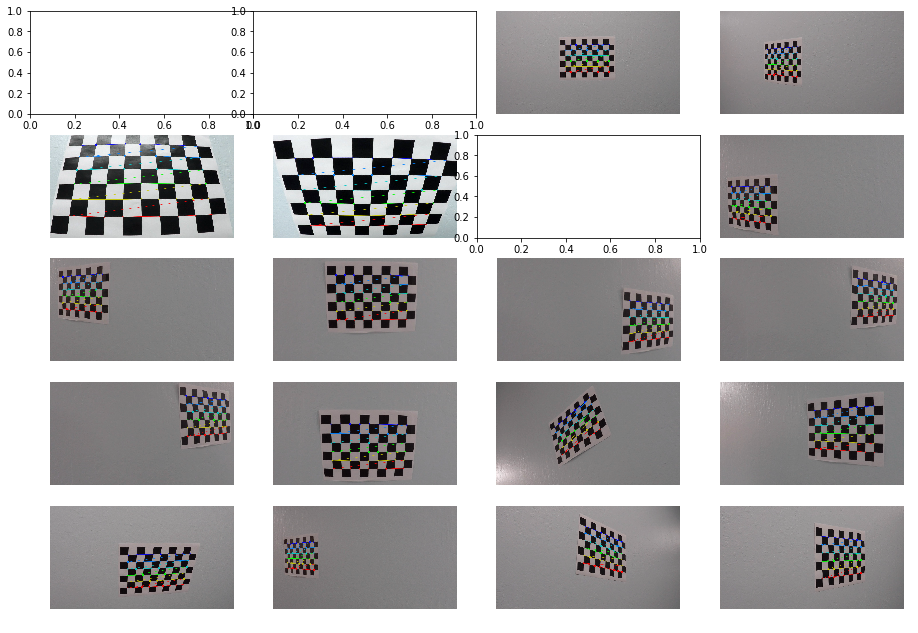

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        #Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
print ('...')

In [4]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# f.subplots_adjust(hspace = .2, wspace=.05)
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(dst)
# ax2.set_title('Undistorted Image', fontsize=30)

print('...')

...


In [5]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

print('...')

...


In [6]:
# Choose an image from which to build and demonstrate each step of the pipeline
exampleImg = cv2.imread('./test_images/test1.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_undistort = undistort(exampleImg)

h,w = exampleImg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
print('...')

...


In [7]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
print('...')

...


In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
        
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
            

print('defined')

defined


In [9]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
print('...')

...


In [10]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


In [11]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


In [12]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh==1)|(img_sobelAbs==1)|(img_BThresh==1)] = 1
    return combined, Minv
    
print('...')

...


In [13]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('defined')

defined


In [14]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('...')

...


In [15]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')


...


In [16]:
def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return ploty, left_fit_cr, right_fit_cr

    
def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit_cr[0]*y_eval+left_fit_cr[1])**2)**1.5)/(np.abs(2*left_fit_cr[0]))  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit_cr[0]*y_eval+right_fit_cr[1])**2)**1.5)/(np.abs(2*right_fit_cr[0]))
    
    return left_curverad*ym_per_pix, right_curverad*ym_per_pix

In [17]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        #rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        #img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
        
    results = tfnet.return_predict(img_out)
    output_frame = boxing(img_out, results)       
    return output_frame

print ('defined')

defined


In [120]:
# l_line = Line()
# r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(22,26)    #50s
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 99%|█████████▉| 100/101 [01:23<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 50s, sys: 3.86 s, total: 1min 54s
Wall time: 1min 23s


In [114]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4').subclip(13,15)      #15s
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 59.6 s, sys: 1.5 s, total: 1min 1s
Wall time: 44.3 s


In [138]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4').subclip(0,5)   #45s
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4



 99%|█████████▉| 125/126 [08:15<00:03,  3.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 10min 38s, sys: 7.74 s, total: 10min 46s
Wall time: 8min 16s
